<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_REINFORCE_lunalander_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
#!sudo pip install box2d-py
import sys
import mxnet  
import gym
import numpy as np  
from mxnet import nd,autograd,init
from mxnet.gluon import nn,trainer
import matplotlib.pyplot as plt
from mxnet.gluon import Trainer

# PolicyNetwork

In [0]:
def build_policy(net,num_actions):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(num_actions))
  return net

test

In [3]:
p = build_policy(nn.HybridSequential(),2)
p.initialize(init=init.Xavier())
x = nd.random.normal(shape=(1,4))
p(x)


[[-0.00842177  0.05223081]]
<NDArray 1x2 @cpu(0)>

# hyperparams

In [0]:
# env
seed = 42
game = 'LunarLander-v2'
env = gym.make(game)
env.seed(seed)

# policy net
policy_net = build_policy(nn.HybridSequential(),env.action_space.n)
policy_net.hybridize()
policy_net.initialize(init=init.Xavier())

# trainer
trainer = Trainer(policy_net.collect_params(),'adam',{'learning_rate':1e-3})

# game params
max_episode_num = 1000
max_steps = 1000

# log list
all_rewards = []
avg_all_rewards = []

# main loop

0 -159.81707992272788
10 -236.79338012421854
20 -204.90012057143787
30 -326.00052210241813
40 -280.9208907431348
50 -270.3852488153485
60 -176.1824352575187
70 -186.48598434081077
80 -124.37201085965293
90 -111.3456178773993
100 -195.4536333161837
110 -298.9811588055669
120 -164.78689774432675
130 -109.14814801368394
140 -96.96964260548667
150 -59.51767209150454
160 -95.71729764539809
170 -46.93071523992692
180 -16.168803148700075
190 -62.35253292595779
200 -51.56419033661863
210 -57.15902218443681
220 -53.53572192519458
230 19.860696182902775
240 -52.740321844416506
250 -43.38943349722349
260 -92.01079137879404
270 64.8197461784222
280 27.611842773297873
290 -17.140740005800353
300 -2.0292505651597663
310 -42.78944845679233
320 13.820048390313525
326 219.3965281539331 solved


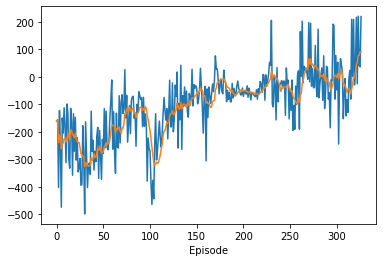

In [5]:
for episode in range(max_episode_num):
  env.seed(seed)
  state = env.reset()
  env.seed(seed)
  log_probs = []
  rewards = []
  with autograd.record():
    for t in range(max_steps):
      state = nd.array(np.expand_dims(state, 0))
      
      probs = nd.softmax(policy_net(state))
      action,log_prob = nd.random.multinomial(probs,get_prob=True)
      
      state, reward, done, _ = env.step(action.asnumpy()[0])
      
      # reward engineering
      #angle_bias = abs(state[2]-0)
      #pos_bias = abs(state[0]-0)
      #reward -= 0.1*angle_bias + 0.1*pos_bias
      
      # store memory
      log_probs.append(log_prob)
      rewards.append(reward)
      
      if done:
        break
    
    # logging
    all_rewards.append(np.sum(rewards))
    avg_all_rewards.append(np.mean(all_rewards[-10:]))

    # reverse accumulate and normalize rewards
    R = 0
    for i in range(len(rewards)-1, -1, -1):
      R = rewards[i] + 0.9 * R
      rewards[i] = R
    rewards = np.array(rewards)
    rewards -= rewards.mean()
    rewards /= rewards.std() #+ np.finfo(rewards.dtype).eps
      
    # compute loss
    loss = []
    for log_prob,Gt in zip(log_probs,rewards):
      loss.append(log_prob*(-Gt))
    
    # loss backward
    autograd.backward(loss)
  
  # gradient descent
  trainer.step(1)
  
  # print info
  if episode % 10 == 0:
    print(episode,avg_all_rewards[-1])
  
  # if solved
  if (all_rewards[-1]>=200)&(avg_all_rewards[-1]>=90):
    print(episode,all_rewards[-1],'solved')
    best_episode = episode
    break

plt.plot(all_rewards)
plt.plot(avg_all_rewards)
plt.xlabel('Episode')
plt.show()

In [0]:
policy_net.export(game,epoch=best_episode)

In [0]:
del policy_net

In [8]:
deserialized_net = nn.SymbolBlock.imports("{}-symbol.json".format(game), 
                                          ['data'], 
                                          "{}-0{}.params".format(game,best_episode))

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [9]:

env = gym.make(game)
env.seed(seed)

policy_net = deserialized_net

for episode in range(10):
  env.seed(seed)
  state = env.reset()
  env.seed(seed)
  rewards = []
  for t in range(1000):
    state = nd.array(np.expand_dims(state, 0))
    
    probs = nd.softmax(policy_net(state))
    action,log_prob = nd.random.multinomial(probs,get_prob=True)
    
    state, reward, done, _ = env.step(action.asnumpy()[0])
    
    rewards.append(reward)
    if done:
      break
  
  # print info
  print(episode,np.sum(rewards))

0 241.20509265207787
1 -9.180155604522724
2 253.91150829834086
3 269.28604453482654
4 268.0895163909396
5 219.92518893845266
6 225.6192300331685
7 62.06328059036452
8 242.20430990347464
9 248.12619676071267
